## Init

In [1]:
repo = "https://github.com/ventus550/HandwritingRecognition"
! ! (git status 2> /dev/null) && git clone {repo}
%cd ShapeCorrection

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
  (commit or discard the untracked or modified content in submodules)
	modified:   ../TkCanvas (untracked content)
	modified:   ETL.ipynb

no changes added to commit (use "git add" and/or "git commit -a")
[Errno 2] No such file or directory: 'ShapeCorrection'
/home/ventus/Documents/ShapeCorrection/notebooks


In [2]:
import sys
sys.path.append("..")

In [3]:
import numpy as np
from pathlib import Path
from PIL import Image, ImageOps
from matplotlib import pyplot as plt

## Configuration

In [4]:
BASEDIR = Path().absolute().parent
DESTDIR = BASEDIR / "data"
DATASET = DESTDIR / "regression"
IMGSSRC = DESTDIR / "images"
VRTSSRC = DESTDIR / "vertices"

In [5]:
shapes = ["other", "ellipse", "rectangle", "triangle"]

## Data loading

In [6]:
def read_image(image_path):
    return 1 - np.array(ImageOps.grayscale(Image.open(image_path))) / 255.0

def read_certs(verts_path):
    return np.genfromtxt(verts_path, delimiter=",")

In [7]:
def load_shape(shape):
	images = IMGSSRC / shape
	vertices = VRTSSRC / shape

	for image_path, verts_path in zip(images.iterdir(), vertices.iterdir()):
		img = read_image(image_path)
		vrt = read_certs(verts_path)
		yield img, vrt

def load_classes():
	for shape in shapes:
		images = IMGSSRC / shape
		for image_path in images.iterdir():
			img = read_image(image_path)
			yield img, shapes.index(shape)

In [8]:
def draw_data_point(x, y, *args):
    points = x.shape * y
    plt.figure(dpi=50)
    plt.axis("off")
    plt.imshow(x, cmap="gray", )
    plt.scatter(points[:, 0], points[:, 1], linewidths=10)

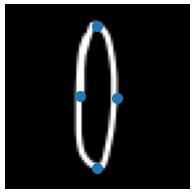

In [9]:
draw_data_point(*next(load_shape("ellipse")))

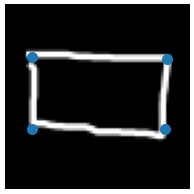

In [10]:
draw_data_point(*next(load_shape("rectangle")))

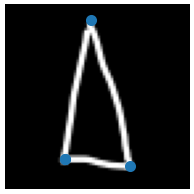

In [11]:
draw_data_point(*next(load_shape("triangle")))

## Data saving

In [12]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b), f"{a.shape, b.shape}"
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [15]:
def save_regression_data(shape):
	X, Y = list(zip(*load_shape(shape)))
	X, Y = np.array(X, dtype=np.float32), np.array(Y, dtype=np.float32)
	X, Y = unison_shuffled_copies(X, Y)
	np.savez(DATASET / shape, X, Y)

def save_classification_data():
	X, Y = [], []
	for shape in shapes[1:]:
		x, y = list(zip(*load_classes()))
		x, y = np.array(x, dtype=np.float32), np.array(np.reshape(y, [-1, 1]), dtype=np.float32)
		X.append(x)
		Y.append(y)
	X, Y = np.concatenate(X), np.concatenate(Y)
	X, Y = unison_shuffled_copies(X, Y)
	np.savez(DESTDIR / "classification", X, Y)

In [16]:
DATASET.mkdir(exist_ok=True)
save_regression_data("ellipse")
save_regression_data("rectangle")
save_regression_data("triangle")
save_classification_data()

## Test serialization

In [17]:
X, Y = np.load(DATASET / "ellipse.npz").values()

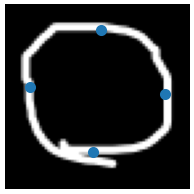

In [18]:
draw_data_point(X[0], Y[0])

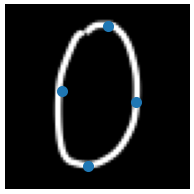

In [19]:
draw_data_point(X[1], Y[1])

In [20]:
X, Y = np.load(DESTDIR / "classification.npz").values()
X.shape, Y.shape

((81876, 70, 70), (81876, 1))

In [21]:
Y[:100].ravel()

array([2., 1., 0., 2., 3., 0., 1., 1., 0., 0., 0., 0., 0., 0., 3., 3., 0.,
       2., 0., 3., 3., 0., 1., 0., 1., 0., 2., 3., 1., 0., 3., 3., 3., 0.,
       2., 2., 1., 1., 2., 1., 1., 2., 3., 2., 2., 0., 0., 0., 0., 3., 2.,
       0., 3., 1., 2., 3., 0., 3., 1., 1., 2., 0., 1., 1., 0., 0., 3., 2.,
       1., 1., 0., 0., 2., 1., 1., 2., 0., 1., 1., 0., 2., 1., 2., 1., 3.,
       0., 0., 0., 2., 0., 1., 0., 0., 2., 1., 3., 3., 3., 2., 3.],
      dtype=float32)